In [43]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import pandas as pd
import cmcrameri as cmcm
import juanfit

In [44]:
df = pd.read_excel("../../save/eis_line_list_final_v2.xlsx",sheet_name="resolve")
df["ion"] = df["ion"].str.strip()
df["charge_stat"] = df["charge_stat"].str.strip()
df["quality"] = df["quality"].str.strip()
df["fwhm_true_err"] = df["fwhm_fit"]/df["fwhm_true"]*df["fwhm_err"]
df

,ion,charge_stat,Z,A,temp,wvl_fit,wvl_chianti,fwhm_fit,fwhm_err,fwhm_true,fwhm_awsom_fit,fwhm_awsom_err,fwhm_awsom_true,quality,desc,fwhm_true_cross,fwhm_true_err
0,Fe,x,9,55.85000,5.9,174.521,174.531,0.07940,0.00150,0.0380,0.082,0.000030,0.0434,a,NaN,0.047998,0.003134
1,Fe,ix,8,55.85000,5.8,176.971,176.945,0.06490,0.00480,NaN,0.081,0.000800,0.0414,c,NaN,0.014541,NaN
2,Fe,x,9,55.85000,5.9,177.230,177.240,0.08078,0.00064,0.0407,0.083,0.000200,0.0440,a,NaN,0.050248,0.001270
3,Fe,xi,10,55.85000,6.0,182.163,182.167,0.07950,0.00180,0.0381,0.086,0.000100,0.0503,a,NaN,0.048163,0.003756
4,Fe,x,9,55.85000,5.9,182.304,182.307,0.08680,0.00370,0.0517,0.082,0.000500,0.0423,b,NaN,0.059445,0.006212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,Mg,vii,6,24.30500,5.8,280.727,280.742,0.07790,0.00740,0.0362,0.097,0.000008,0.0676,b,NaN,0.045474,0.015924
80,Al,ix,8,26.98154,5.9,282.415,282.422,0.09300,0.01600,0.0629,0.103,0.000080,0.0755,b,NaN,0.068179,0.023657
81,Al,ix,8,26.98154,5.9,284.032,284.042,0.09120,0.00760,0.0594,0.113,0.001000,0.0882,b,NaN,0.065703,0.011669
82,Fe,xv,14,55.85000,6.2,284.161,284.163,0.05600,0.00870,NaN,0.094,0.002000,0.0623,c,sim too hot,NaN,NaN


In [45]:
for index,row in df.iterrows():
    print(row["ion"],row["charge_stat"],row["wvl_chianti"],row["fwhm_true"],"{:.4f}".format(row["fwhm_true_err"]))

Fe x 174.531 0.038 0.0031
Fe ix 176.945 nan nan
Fe x 177.24 0.0407 0.0013
Fe xi 182.167 0.0381 0.0038
Fe x 182.307 0.0517 0.0062
O vi 183.937 0.0602 0.0086
O vi 184.117 0.0421 0.0027
Fe x 184.537 0.0356 0.0011
Fe viii 185.213 0.0314 0.0011
Mn viii 185.463 0.0447 0.0072
Fe viii 186.598 0.0388 0.0015
Fe viii 187.24 0.0683 0.0073
Fe xi 188.216 0.039 0.0007
Fe xi 188.299 0.039 0.0007
Fe xi 188.997 0.0505 0.0341
Fe ix 189.572 0.0198 0.0364
Fe xi 189.711 0.0497 0.0208
Fe ix 189.935 0.0291 0.0016
Fe x 190.037 0.0389 0.0011
Fe xi 190.382 0.0546 0.0148
Fe ix 191.206 0.0331 0.0042
Mn ix 191.635 0.0569 0.0063
Fe xii 192.394 0.0419 0.0047
Fe xi 192.627 0.0427 0.0031
Fe xii 193.509 0.0404 0.0010
Fe x 193.715 0.0346 0.0027
Fe viii 193.968 nan nan
Mn x 194.299 0.0306 0.0075
Fe viii 194.661 0.0331 0.0011
Fe xii 195.119 0.0475 0.0009
Fe vii 195.484 nan nan
Fe viii 195.972 0.0496 0.0013
Fe vii 196.213 0.0388 0.0247
Fe xiii 196.525 nan nan
Fe viii 197.362 0.055 0.0026
Fe ix 197.854 0.041 0.0007
Ni xi 198

In [46]:
df_test = df.loc[(df["ion"] == "Fe") & (df["charge_stat"] == "xi") & (df["quality"] == "a")]

In [47]:
def aver_err(data,err,thresh=1.e-5,iter_max=1000):
    sigma_sq = np.var(data)
    n_data = len(data)

    if type(data) is list:
        data = np.array(data)
    if type(err) is list:
        err = np.array(err)

    err_sq_mean = np.mean(np.square(err)) 
    for ii in range(iter_max):
        weight = 1./(sigma_sq + err**2)
        weight = weight/np.sum(weight)
        aver_new = np.sum(weight*data)
        sigma_new_sq = np.max([0.,n_data/(n_data - 1.)*np.sum(weight*np.square(data-aver_new)) - \
                                err_sq_mean])
        
        #print(aver_new,sigma_new_sq)
        if ((sigma_new_sq <= sigma_sq*(1+thresh)) and (sigma_sq <= sigma_new_sq*(1+thresh))):
            break
        else:
            sigma_sq = sigma_new_sq
        
    # if sigma_new_sq == 0:
    #     print("sigma_new is 0.")

    sigma_tot = np.sqrt(1./np.sum(1./(sigma_new_sq + err**2)))
    return aver_new, sigma_tot, sigma_new_sq

# print(aver_err([10,12,7,8],[0.8,1.2,0.5,1.5]))

# aver_bootstrap = np.zeros(5000)
# for ii in range(5000):
#     data = np.random.normal(9.1673963016428,np.sqrt(3.8011034789338853),4)
#     epsilon = np.random.normal(0,[0.8,1.2,0.5,1.5])
#     data_gen = data + epsilon
#     aver_bootstrap[ii], _, _ = aver_err(data_gen,[0.8,1.2,0.5,1.5]) 

# print(np.percentile(aver_bootstrap,[2.5,50,97.5]))

In [48]:
def plot_eis_awsom_width(df,ion,charge=None,quality="a",plot_awsom=True,plot_mle=False,print_df=True,
                        print_veff=False,save_fig=False,save_fname=None,bootstrap=True):
    c = const.c.cgs/1.e5

    if type(ion) is str:
        ion = [ion]
    if type(charge) is str:
        charge = [charge]
    if type(quality) is str:
        quality = [quality]
    
    if charge is None:
        df_plot = df[(df["ion"].isin(ion)) & (df["quality"].isin(quality))]
    else:
        df_plot = df[(df["ion"].isin(ion)) & (df["charge_stat"].isin(charge)) \
                    & (df["quality"].isin(quality))]

    line_name = df_plot["ion"] + r" \textsc{"+ df_plot["charge_stat"] + r"} " + \
         ((df_plot["wvl_chianti"].values).astype("int")).astype("str")

    eis_veff = df_plot["fwhm_true"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    awsom_veff = df_plot["fwhm_awsom_true"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    eis_veff_err = df_plot["fwhm_err"]*df_plot["fwhm_fit"] \
                    /df_plot["fwhm_true"]/df_plot["wvl_chianti"]*c/np.sqrt(4*np.log(2))

    awsom_veff_err = df_plot["fwhm_awsom_err"]*df_plot["fwhm_awsom_fit"] \
                    /df_plot["fwhm_awsom_true"]/df_plot["wvl_chianti"]*c//np.sqrt(4*np.log(2))


    n_lines = len(df_plot.index)
    plot_x = np.arange(n_lines)

    fig, ax = plt.subplots(figsize=(n_lines*1.2+2,6),constrained_layout=True)

    if plot_mle is True:
        best_est,err_tot, err_est_sq = aver_err(eis_veff,eis_veff_err)
        best_low1sig,best_up1sig = best_est - err_tot, best_est + err_tot
        best_low3sig,best_up3sig = best_est - 3*err_tot, best_est + 3*err_tot
        aver_bootstrap = np.zeros(10000)
        if bootstrap is True:
            for ii in range(10000):
                data = np.random.normal(best_est,np.sqrt(err_est_sq),len(eis_veff))
                epsilon = np.random.normal(0,eis_veff_err)
                data_gen = data + epsilon
                aver_bootstrap[ii], _, _ = aver_err(data_gen,eis_veff_err) 
            best_low3sig,best_low1sig,best_est,best_up1sig,best_up1sigbest_up3sig = \
                np.percentile(aver_bootstrap,[0.15,16,50,84,99.85])



        ax.axhspan(best_low1sig,best_up1sig,color="#FAD689",alpha=0.9)
        ax.axhspan(best_low3sig,best_up3sig,color="#FAD689",alpha=0.5)
        ax.axhline(best_est,color="#FFB11B",lw=2,ls="--",label=r"$\bar{v}_{\rm eff}$")
    
    if plot_awsom:
        ax.errorbar(plot_x,awsom_veff,awsom_veff_err,color="#0089A7",ls="none",marker="d",
                    markersize=6,capsize=5,lw=2,label="AWSoM",zorder=15)
    ax.errorbar(plot_x,eis_veff,eis_veff_err,color="#CC543A",ls="none",marker="o",
                markersize=6,capsize=5,lw=2,label="EIS",zorder=15)


    # ax.scatter(plot_x,awsom_veff,color="#0089A7",marker="o",
    #             lw=3,label="AWSoM",zorder=14)


    ax.set_xlim(left=-1,right=len(line_name))
    ax.set_xticks(plot_x)
    ax.set_xticklabels(line_name)
    ax.tick_params(labelsize=16)
    ax.set_xlabel("Line",fontsize=16)
    ax.set_ylabel(r"Effective Velocity $v_{\rm eff}\ \left[\mathrm{km \cdot s^{-1}} \right]$",
                    fontsize=16)

    if charge is not None:
        title = r"\textbf{" + ion[0] + ' '.join([r" \textsc{" + charge_ +r"} " for charge_ in charge]) + \
                r"}"
    else:
        title = r"\textbf{" + ion[0] + r"}"

    if (plot_mle is True) and (bootstrap is False):
        title = title + r" $\bar{{v}}_{{\rm eff}} = {{{:.1f}}}\pm{{{:.1f}}}\ \left[\mathrm{{km \cdot s^{{-1}}}}\right]$".format(best_est,err_tot)
    elif (plot_mle is True) and (bootstrap is True):
        title = title + \
        r" $\bar{{v}}_{{\rm eff}} = {{{:.1f}}}_{{-{:.1f}}}^{{+{:.1f}}}\ \left[\mathrm{{km \cdot s^{{-1}}}}\right]$". \
            format(best_est,best_est-best_low1sig,best_up1sig-best_est)
    ax.set_title(title,fontsize=18,pad=10)
    ax.tick_params(which="major",width=1.2,length=8,direction="in")
    ax.tick_params(which="minor",width=1.2,length=4,direction="in")
    ax.grid("on")
    ax.legend(loc = 'lower left',fontsize = 18,frameon=False,handlelength=1)

    if print_df:
        print(df_plot)

    if print_veff:
        print(eis_veff)
        print(eis_veff_err)

    if save_fig:
        plt.savefig(fname=save_fname,format=save_fname[-3:])

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
32  Fe         vii  6  55.85   5.7  196.206      196.213      0.08     0.012   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
32     0.0388           0.083           0.001           0.0449       b  NaN   

    fwhm_true_cross  fwhm_true_err  
32         0.048984       0.024742  
32    35.602617
dtype: float64
32    22.703338
dtype: float64


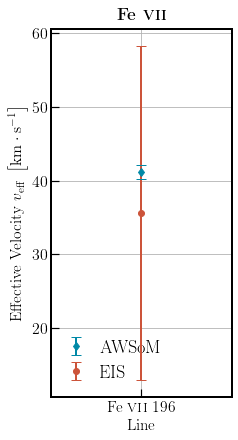

In [49]:
plot_eis_awsom_width(df,"Fe","vii",quality=["a","b"],print_veff=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
8   Fe        viii  7  55.85   5.8  185.209      185.213   0.07648   0.00044   
10  Fe        viii  7  55.85   5.8  186.600      186.598   0.07981   0.00072   
28  Fe        viii  7  55.85   5.8  194.656      194.661   0.07716   0.00049   
51  Fe        viii  7  55.85   5.8  253.947      253.956   0.07980   0.00280   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality  \
8      0.0314           0.082         0.00002           0.0418       a   
10     0.0388           0.082         0.00004           0.0432       a   
28     0.0331           0.083         0.00007           0.0453       a   
51     0.0396           0.091         0.00020           0.0575       a   

                 desc  fwhm_true_cross  fwhm_true_err  
8                 NaN         0.042996       0.001072  
10                NaN         0.048673       0.001481  
28                NaN         0.044194       0.001142  
51  

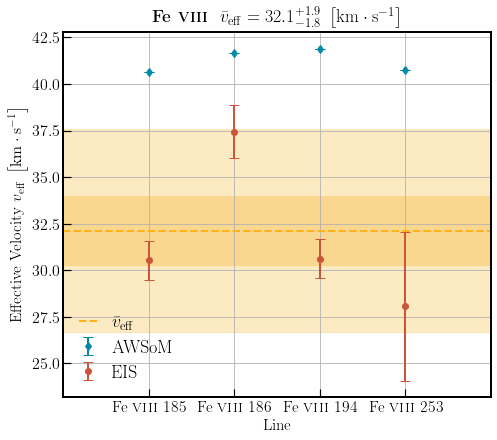

In [50]:
plot_eis_awsom_width(df,"Fe","viii",quality=["a"],plot_mle=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
8   Fe        viii  7  55.85   5.8  185.209      185.213   0.07648   0.00044   
10  Fe        viii  7  55.85   5.8  186.600      186.598   0.07981   0.00072   
11  Fe        viii  7  55.85   5.8  187.234      187.240   0.09740   0.00510   
28  Fe        viii  7  55.85   5.8  194.656      194.661   0.07716   0.00049   
31  Fe        viii  7  55.85   5.8  195.969      195.972   0.08510   0.00076   
34  Fe        viii  7  55.85   5.8  197.366      197.362   0.08860   0.00160   
45  Fe        viii  7  55.85   5.8  204.701      204.704   0.07390   0.00280   
51  Fe        viii  7  55.85   5.8  253.947      253.956   0.07980   0.00280   
56  Fe        viii  7  55.85   5.8  255.666      255.684   0.09500   0.02600   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality  \
8      0.0314           0.082        0.000020           0.0418       a   
10     0.0388           0.082        0.000040      

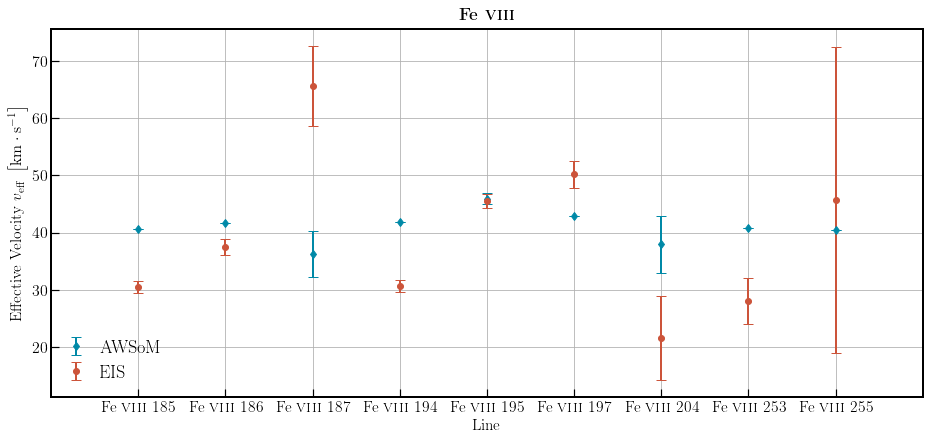

In [51]:
plot_eis_awsom_width(df,"Fe","viii",quality=["a","b"])

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
17  Fe          ix  8  55.85   5.8  189.933      189.935   0.07530   0.00060   
20  Fe          ix  8  55.85   5.8  191.209      191.206   0.07710   0.00180   
35  Fe          ix  8  55.85   5.8  197.856      197.854   0.08085   0.00035   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
17     0.0291           0.083         0.00004           0.0441       a  NaN   
20     0.0331           0.087         0.00090           0.0520       a  NaN   
35     0.0410           0.084         0.00002           0.0467       a  NaN   

    fwhm_true_cross  fwhm_true_err  
17         0.040860       0.001553  
20         0.044089       0.004193  
35         0.050360       0.000690  


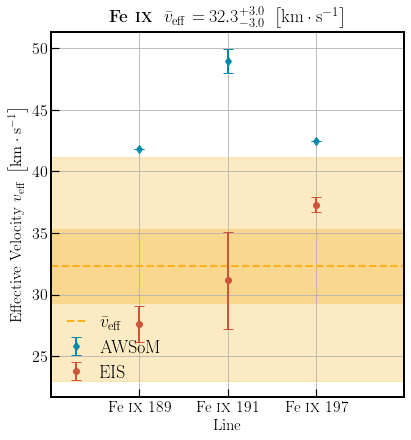

In [52]:
plot_eis_awsom_width(df,"Fe","ix",quality=["a"],plot_mle=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
0   Fe           x  9  55.85   5.9  174.521      174.531   0.07940   0.00150   
2   Fe           x  9  55.85   5.9  177.230      177.240   0.08078   0.00064   
7   Fe           x  9  55.85   5.9  184.533      184.537   0.07828   0.00052   
18  Fe           x  9  55.85   5.9  190.034      190.037   0.07978   0.00056   
25  Fe           x  9  55.85   5.9  193.711      193.715   0.07780   0.00120   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
0      0.0380           0.082         0.00003           0.0434       a  NaN   
2      0.0407           0.083         0.00020           0.0440       a  NaN   
7      0.0356           0.084         0.00010           0.0457       a  NaN   
18     0.0389           0.085         0.00003           0.0481       a  NaN   
25     0.0346           0.084         0.00100           0.0470       a  NaN   

    fwhm_true_cross  fwhm_true_err  
0      

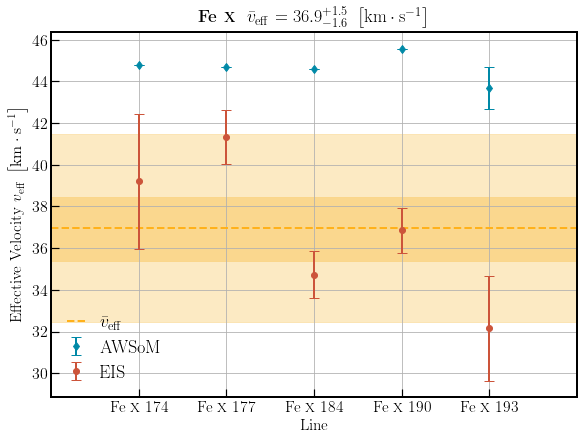

In [53]:
plot_eis_awsom_width(df,"Fe","x",quality=["a"],plot_mle=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
0   Fe           x  9  55.85   5.9  174.521      174.531   0.07940   0.00150   
2   Fe           x  9  55.85   5.9  177.230      177.240   0.08078   0.00064   
4   Fe           x  9  55.85   5.9  182.304      182.307   0.08680   0.00370   
7   Fe           x  9  55.85   5.9  184.533      184.537   0.07828   0.00052   
18  Fe           x  9  55.85   5.9  190.034      190.037   0.07978   0.00056   
25  Fe           x  9  55.85   5.9  193.711      193.715   0.07780   0.00120   
38  Fe           x  9  55.85   5.9  201.572      201.565   0.08410   0.00340   
47  Fe           x  9  55.85   5.9  207.448      207.448   0.07100   0.00180   
66  Fe           x  9  55.85   5.9  266.092      266.049   0.09200   0.01500   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality  \
0      0.0380           0.082         0.00003           0.0434       a   
2      0.0407           0.083         0.00020      

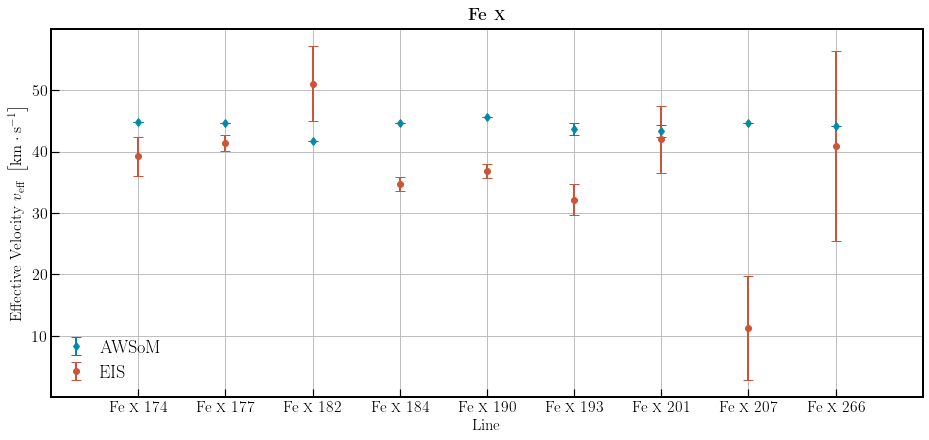

In [54]:
plot_eis_awsom_width(df,"Fe","x",quality=["a","b"],plot_mle=False)

   ion charge_stat   Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
3   Fe          xi  10  55.85   6.0  182.163      182.167   0.07950   0.00180   
12  Fe          xi  10  55.85   6.0  188.214      188.216   0.08034   0.00034   
13  Fe          xi  10  55.85   6.0  188.300      188.299   0.08034   0.00034   
23  Fe          xi  10  55.85   6.0  192.626      192.627   0.08170   0.00160   
41  Fe          xi  10  55.85   6.0  202.424      202.424   0.08660   0.00300   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
3      0.0381           0.086         0.00010           0.0503       a  NaN   
12     0.0390           0.087         0.00007           0.0522       a  NaN   
13     0.0390           0.087         0.00007           0.0522       a  NaN   
23     0.0427           0.085         0.00100           0.0488       a  NaN   
41     0.0514           0.089         0.00010           0.0553       a  NaN   

    fwhm_true_cross  fwhm_true_err  
3

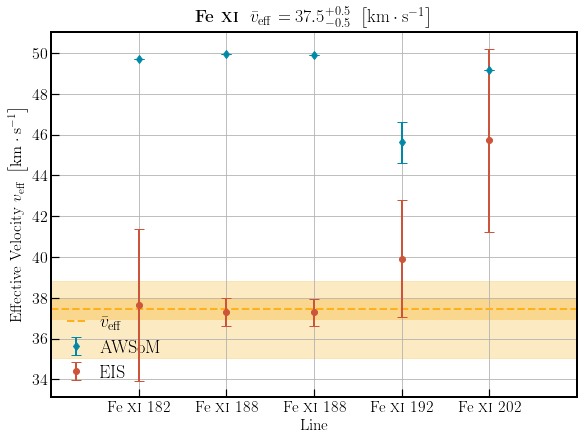

In [55]:
plot_eis_awsom_width(df,"Fe","xi",quality=["a"],plot_mle=True,print_veff=True)

   ion charge_stat   Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
3   Fe          xi  10  55.85   6.0  182.163      182.167   0.07950   0.00180   
12  Fe          xi  10  55.85   6.0  188.214      188.216   0.08034   0.00034   
13  Fe          xi  10  55.85   6.0  188.300      188.299   0.08034   0.00034   
16  Fe          xi  10  55.85   6.0  189.721      189.711   0.08600   0.01200   
19  Fe          xi  10  55.85   6.0  190.379      190.382   0.08860   0.00910   
23  Fe          xi  10  55.85   6.0  192.626      192.627   0.08170   0.00160   
39  Fe          xi  10  55.85   6.0  201.732      201.734   0.07680   0.00520   
41  Fe          xi  10  55.85   6.0  202.424      202.424   0.08660   0.00300   
57  Fe          xi  10  55.85   6.0  256.920      256.919   0.08620   0.00410   
58  Fe          xi  10  55.85   6.0  257.762      257.772   0.08800   0.02200   
65  Fe          xi  10  55.85   6.0  264.776      264.772   0.08290   0.00800   

    fwhm_true  fwhm_awsom_f

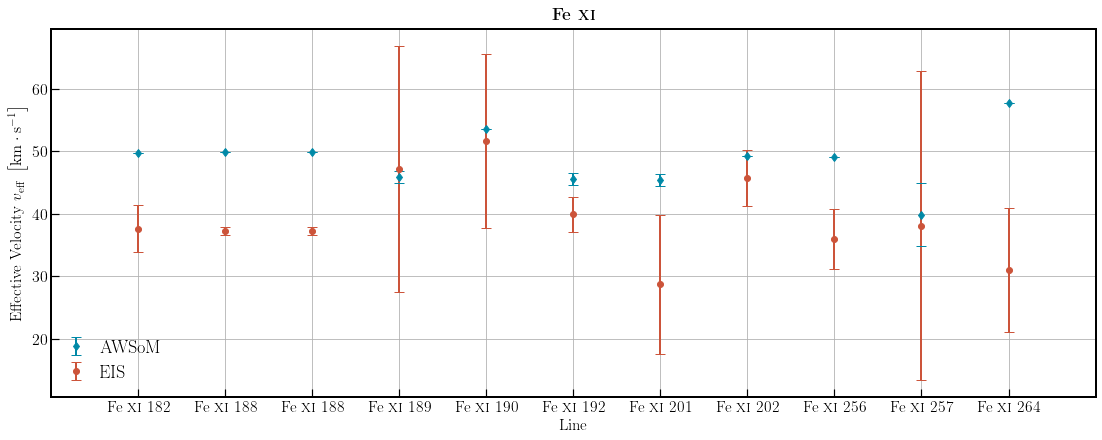

In [56]:
plot_eis_awsom_width(df,"Fe","xi",quality=["a","b"],plot_mle=False)

   ion charge_stat   Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
22  Fe         xii  11  55.85   6.1  192.394      192.394   0.08130   0.00240   
24  Fe         xii  11  55.85   6.1  193.509      193.509   0.08057   0.00052   
29  Fe         xii  11  55.85   6.1  195.123      195.119   0.08436   0.00051   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
22     0.0419           0.092          0.0003           0.0593       a  NaN   
24     0.0404           0.092          0.0003           0.0594       a  NaN   
29     0.0475           0.093          0.0004           0.0613       a  NaN   

    fwhm_true_cross  fwhm_true_err  
22         0.051080       0.004657  
24         0.049910       0.001037  
29         0.055822       0.000906  


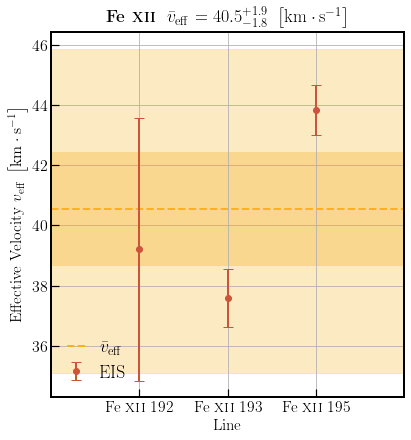

In [57]:
plot_eis_awsom_width(df,"Fe","xii",quality=["a"],plot_mle=True,save_fig=True,plot_awsom=False,
save_fname="../../figs/ms/FeXII_summary.pdf")

   ion charge_stat   Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
22  Fe         xii  11  55.85   6.1  192.394      192.394   0.08130   0.00240   
24  Fe         xii  11  55.85   6.1  193.509      193.509   0.08057   0.00052   
29  Fe         xii  11  55.85   6.1  195.123      195.119   0.08436   0.00051   
62  Fe         xii  11  55.85   6.1  259.970      259.973   0.08500   0.01600   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
22     0.0419           0.092          0.0003           0.0593       a  NaN   
24     0.0404           0.092          0.0003           0.0594       a  NaN   
29     0.0475           0.093          0.0004           0.0613       a  NaN   
62     0.0498           0.107          0.0008           0.0813       b  NaN   

    fwhm_true_cross  fwhm_true_err  
22         0.051080       0.004657  
24         0.049910       0.001037  
29         0.055822       0.000906  
62         0.056784       0.027309  


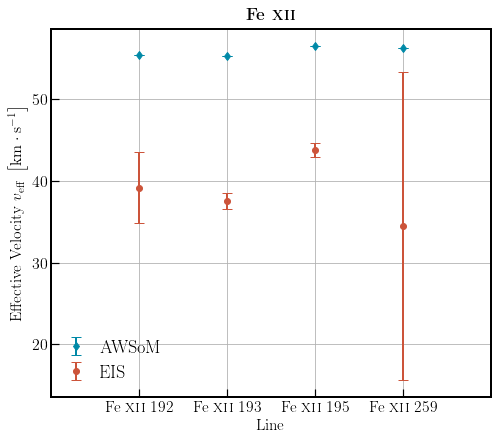

In [58]:
plot_eis_awsom_width(df,"Fe","xii",quality=["a","b"])

   ion charge_stat   Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
40  Fe        xiii  12  55.85   6.1  202.051      202.044    0.0821    0.0013   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
40     0.0435           0.098           0.001           0.0691       a  NaN   

    fwhm_true_cross  fwhm_true_err  
40         0.052344       0.002454  
40    38.763348
dtype: float64
40    2.186398
dtype: float64


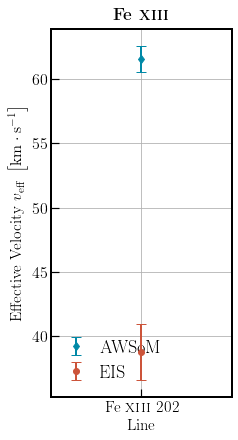

In [59]:
plot_eis_awsom_width(df,"Fe",["xiii"],quality=["a"],print_veff=True)

  ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
6   O          vi  5  15.9994   5.6  184.116      184.117    0.0814    0.0014   

   fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
6     0.0421           0.085           0.001            0.048       a  NaN   

   fwhm_true_cross  fwhm_true_err  
6         0.051239       0.002707  
6    41.168608
dtype: float64
6    2.647003
dtype: float64


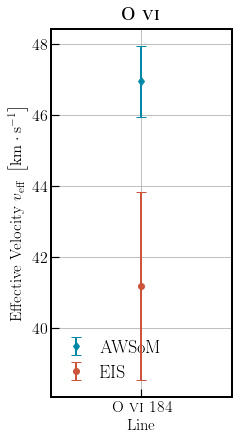

In [60]:
plot_eis_awsom_width(df,"O",["vi"],quality=["a"],print_veff=True)

  ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
5   O          vi  5  15.9994   5.6  183.927      183.937    0.0921    0.0056   
6   O          vi  5  15.9994   5.6  184.116      184.117    0.0814    0.0014   

   fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
5     0.0602           0.086           0.003           0.0499       b  NaN   
6     0.0421           0.085           0.001           0.0480       a  NaN   

   fwhm_true_cross  fwhm_true_err  
5         0.066947       0.008567  
6         0.051239       0.002707  


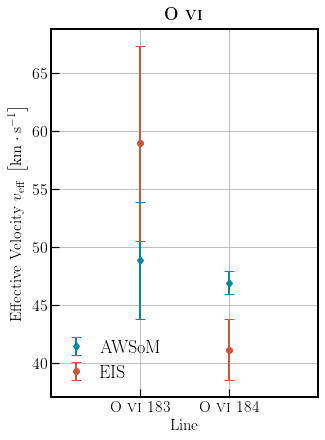

In [61]:
plot_eis_awsom_width(df,"O",["vi"],quality=["a","b"])

   ion charge_stat  Z       A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
74  Mg         vii  6  24.305   5.8  276.137      276.154    0.0909    0.0033   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
74     0.0591           0.096          0.0001           0.0662       a  NaN   

    fwhm_true_cross  fwhm_true_err  
74         0.065286       0.005076  
74    38.531341
dtype: float64
74    3.309154
dtype: float64


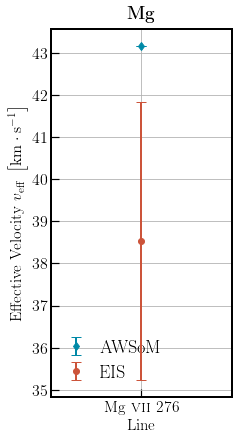

In [62]:
plot_eis_awsom_width(df,"Mg",quality=["a"],print_veff=True)

   ion charge_stat  Z       A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
68  Mg          vi  5  24.305   5.7  268.982      268.991    0.0880    0.0120   
74  Mg         vii  6  24.305   5.8  276.137      276.154    0.0909    0.0033   
79  Mg         vii  6  24.305   5.8  280.727      280.742    0.0779    0.0074   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
68     0.0545           0.095        0.000008           0.0637       b  NaN   
74     0.0591           0.096        0.000100           0.0662       a  NaN   
79     0.0362           0.097        0.000008           0.0676       b  NaN   

    fwhm_true_cross  fwhm_true_err  
68         0.061184       0.019376  
74         0.065286       0.005076  
79         0.045474       0.015924  
68    36.478480
74    38.531341
79    23.215560
dtype: float64
68    12.969034
74     3.309154
79    10.212479
dtype: float64


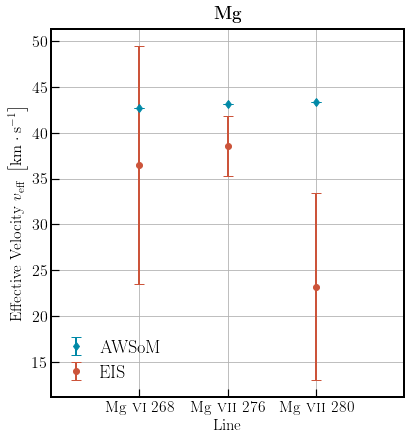

In [63]:
plot_eis_awsom_width(df,"Mg",quality=["a","b"],print_veff=True)

   ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
60  Si           x  9  28.0855   6.0  258.371      258.374    0.0878   
63  Si           x  9  28.0855   6.0  261.054      261.056    0.0851   

    fwhm_err  fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true  \
60    0.0026     0.0541           0.105          0.0002           0.0777   
63    0.0048     0.0494           0.106          0.0002           0.0790   

   quality desc  fwhm_true_cross  fwhm_true_err  
60       a  NaN         0.060896       0.004220  
63       a  NaN         0.056934       0.008269  


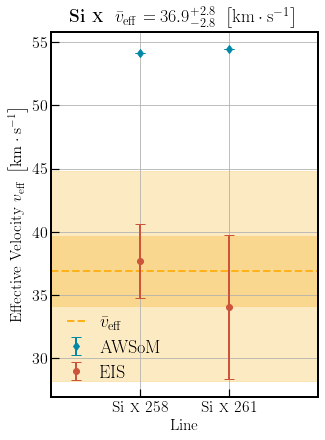

In [64]:
plot_eis_awsom_width(df,"Si","x",quality=["a"],plot_mle=True)

   ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
71  Si         vii  6  28.0855   5.8  272.642      272.647   0.09120   
72  Si         vii  6  28.0855   5.8  275.363      275.361   0.09165   
73  Si         vii  6  28.0855   5.8  275.678      275.675   0.08950   

    fwhm_err  fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true  \
71   0.00150     0.0594           0.096         0.00002           0.0656   
72   0.00051     0.0601           0.096         0.00002           0.0663   
73   0.00250     0.0569           0.096         0.00002           0.0663   

   quality desc  fwhm_true_cross  fwhm_true_err  
71       a  NaN         0.065703       0.002303  
72       a  NaN         0.066326       0.000778  
73       a  NaN         0.063322       0.003932  


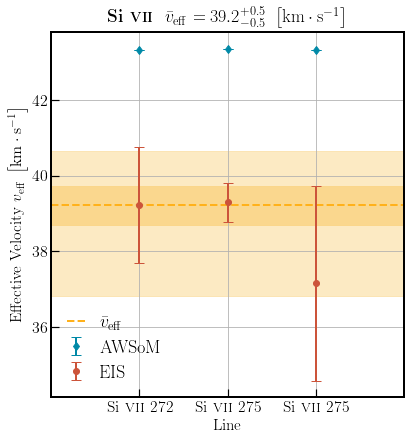

In [65]:
plot_eis_awsom_width(df,"Si","vii",quality=["a"],plot_mle=True)

   ion charge_stat  Z        A  temp  wvl_fit  wvl_chianti  fwhm_fit  \
59  Si          ix  8  28.0855   5.9  258.087       258.08     0.086   

    fwhm_err  fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true  \
59     0.018     0.0503           0.095           0.002           0.0645   

   quality                desc  fwhm_true_cross  fwhm_true_err  
59       b  Fe XI at blue wing          0.05827       0.030775  
59    35.090666
dtype: float64
59    21.469731
dtype: float64


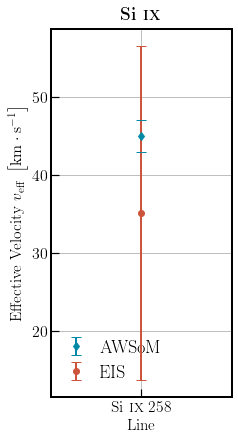

In [66]:
plot_eis_awsom_width(df,"Si","ix",quality=["a","b"],print_veff=True)

   ion charge_stat  Z      A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
61   S           x  9  32.06   6.0  259.500      259.496    0.0920    0.0100   
64   S           x  9  32.06   6.0  264.233      264.230    0.0866    0.0059   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality  \
61     0.0605           0.109          0.0030           0.0842       a   
64     0.0520           0.107          0.0005           0.0804       a   

                  desc  fwhm_true_cross  fwhm_true_err  
61  sim bl with Fe XII         0.066809       0.015207  
64                 NaN         0.059152       0.009826  
61    41.976158
64    35.432288
dtype: float64
61    10.550663
64     6.695182
dtype: float64


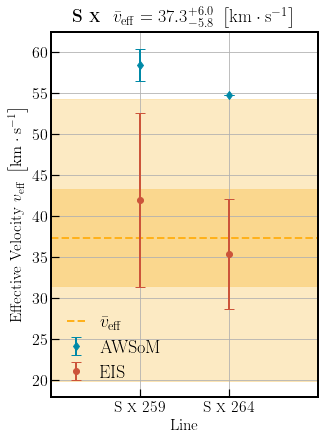

In [67]:
plot_eis_awsom_width(df,"S","x",quality=["a"],plot_mle=True,print_veff=True)

   ion charge_stat  Z       A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
9   Mn        viii  7  54.938   5.8  185.449      185.463    0.0828    0.0039   
21  Mn          ix  8  54.938   5.9  191.604      191.635    0.0900    0.0040   
27  Mn           x  9  54.938   5.9  194.323      194.299    0.0762    0.0030   
37  Mn          ix  8  54.938   5.9  199.317      199.318    0.0727    0.0080   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality  \
9      0.0447           0.082          0.0001           0.0423       b   
21     0.0569           0.083          0.0005           0.0445       b   
27     0.0306           0.086          0.0005           0.0504       a   
37     0.0208           0.088          0.0020           0.0532       b   

              desc  fwhm_true_cross  fwhm_true_err  
9   bl with Fe VII         0.053435       0.007224  
21             NaN         0.064027       0.006327  
27             NaN         0.042496       0.007471  
37         

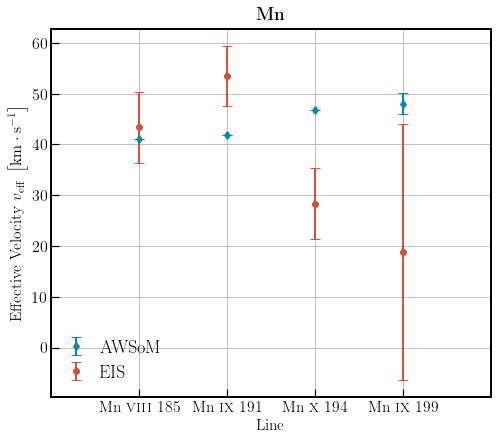

In [68]:
plot_eis_awsom_width(df,"Mn",quality=["a","b"],print_veff=True)

   ion charge_stat  Z       A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
43  Cr         vii  6  51.996   5.8  202.832      202.825    0.0896    0.0063   
46  Cr        viii  7  51.996   5.8  205.030      205.010    0.0781    0.0023   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality  \
43     0.0563           0.083          0.0004           0.0441       b   
46     0.0352           0.101          0.0020           0.0722       b   

                   desc  fwhm_true_cross  fwhm_true_err  
43                  NaN         0.063463       0.010026  
46  sim bl with Fe XIII         0.045815       0.005103  
43    49.976391
46    30.913316
dtype: float64
43    8.900136
46    4.481662
dtype: float64


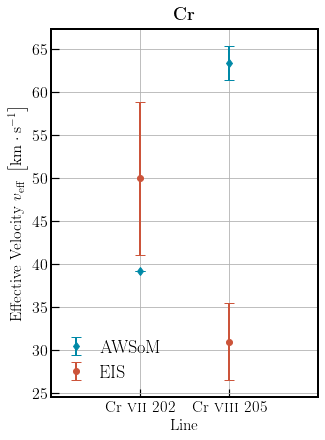

In [69]:
plot_eis_awsom_width(df,"Cr",quality=["a","b"],print_veff=True)

   ion charge_stat   Z     A  temp  wvl_fit  wvl_chianti  fwhm_fit  fwhm_err  \
36  Ni          xi  10  58.7   5.9  198.422      198.424    0.0969    0.0082   

    fwhm_true  fwhm_awsom_fit  fwhm_awsom_err  fwhm_awsom_true quality desc  \
36     0.0673           0.088          0.0004           0.0539       b  NaN   

    fwhm_true_cross  fwhm_true_err  
36          0.07341       0.011807  
36    61.065911
dtype: float64
36    10.712883
dtype: float64


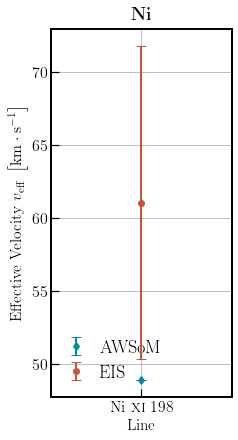

In [70]:
plot_eis_awsom_width(df,"Ni",quality=["a","b"],print_veff=True)